In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # root_dir 안에 있는 모든 파일을 리스트로 저장
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, 0  # 더미 라벨 0을 반환


# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
])

# 데이터셋 생성
train_dataset = CustomDataset(root_dir='train_224', transform=transform)
val_dataset = CustomDataset(root_dir='val_224', transform=transform)

# 로드된 이미지 수 출력
print(f'Number of images in the training dataset: {len(train_dataset)}')
print(f'Number of images in the validation dataset: {len(val_dataset)}')

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Custom Train and Validation DataLoaders are ready.")


Number of images in the training dataset: 147448
Number of images in the validation dataset: 36862
Custom Train and Validation DataLoaders are ready.


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# GPU가 사용 가능한지 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        
        # ResNet 모델 로드 및 수정
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # pretrained=True 대신 weights 사용
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # 마지막 두 개의 레이어를 제외하여 특징 추출 부분만 사용
        
        # Latent space
        self.flatten = nn.Flatten()
        self.latent = nn.Linear(2048 * 7 * 7, 256)
        
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(256, 2048 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (2048, 7, 7)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)  # ResNet encoder
        x = self.flatten(x)
        x = self.latent(x)  # Latent space
        x = self.decoder(x)  # Decoder
        return x

In [4]:

# 모델 인스턴스 생성 및 GPU로 이동
model = ResNetAutoencoder().to(device)

# 모델 요약 정보 출력
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [5]:
# 모델 초기화 및 GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, _ in dataloader:  # 라벨 부분은 무시
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, _ in dataloader:  # 라벨 부분은 무시
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            
            running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [11]:
# 모델 학습
num_epochs = 100
best_val_loss = float('inf')
patience = 3
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # 매 에포크마다 모델 저장
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'model_best.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping")
        break

Epoch 1/100, Train Loss: 0.0046, Validation Loss: 0.0005
Epoch 2/100, Train Loss: 0.0004, Validation Loss: 0.0003
Epoch 3/100, Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 4/100, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 5/100, Train Loss: 0.0001, Validation Loss: 0.0002
Epoch 6/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 7/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 8/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 9/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 10/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 11/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 12/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15/100, Train Loss: 0.0001, Validation Loss: 0.0000
Epoch 16/100, Train Loss: 0.0001, Validation Loss: 0.0000
Epoch 17/100, Train Loss: 0.0001, Validation Loss: 0.0000
Epoch 18/100, Train Los

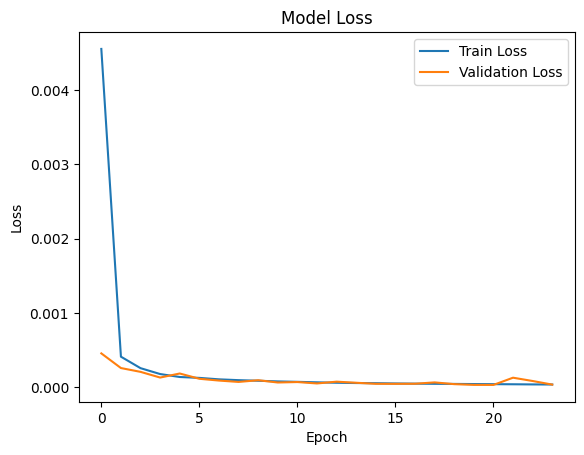

In [12]:
# 학습 손실율 그래프
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# CSV 파일에서 라벨 불러오기
csv_path = 'attack_labels.csv'
label_df = pd.read_csv(csv_path)

# 이미지 파일명과 라벨을 매핑 (이미지 파일명은 자동 생성)
image_paths = [f"image_{i}.png" for i in range(len(label_df))]
labels = label_df['Label'].tolist()  # 'Label' 열 사용

In [20]:
# 사용자 정의 데이터셋 클래스
class CustomTestDataset(Dataset):
    def __init__(self, image_dir, image_paths, labels, transform=None):
        self.image_dir = image_dir
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

In [21]:
# 이미지 전처리
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 데이터셋 생성
test_dataset = CustomTestDataset(image_dir='test_224', image_paths=image_paths, labels=labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Optimal Threshold: 0.007269254067178928
Best F1 Score: 0.2747117267387048


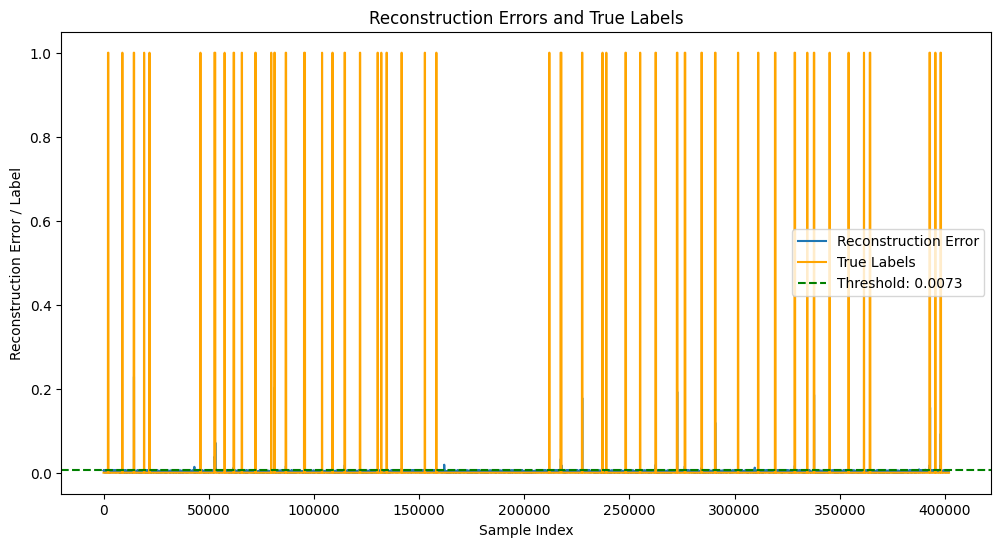

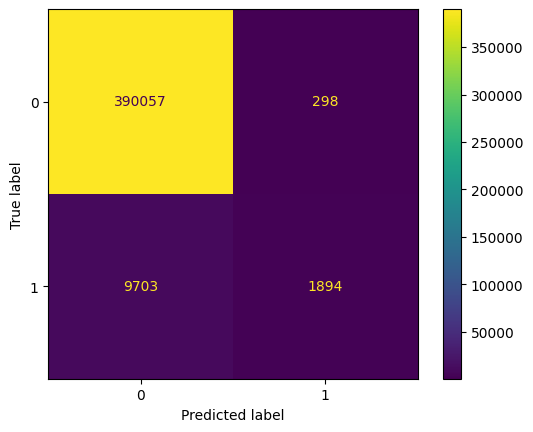

F1 Score: 0.2747117267387048


In [23]:
# 모델 불러오기 및 GPU로 이동
model = ResNetAutoencoder()
model.load_state_dict(torch.load('./model_best.pth'))
model.to(device)  # 모델을 GPU로 이동
model.eval()

# 재구성 오차 계산
reconstruction_errors = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        imgs, labels = data
        imgs = imgs.to(device)  # 입력도 GPU로 이동
        outputs = model(imgs)  # 모델은 이미 GPU에 있음
        loss = torch.mean((imgs - outputs) ** 2, dim=[1, 2, 3])
        reconstruction_errors.extend(loss.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
test_labels = np.array(test_labels)

# 최적의 임계값 찾기
thresholds = np.linspace(min(reconstruction_errors), max(reconstruction_errors), 100)
f1_scores = []

for threshold in thresholds:
    predicted_labels = (reconstruction_errors > threshold).astype(int)
    f1 = f1_score(test_labels != 0, predicted_labels)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f'Optimal Threshold: {optimal_threshold}')
print(f'Best F1 Score: {max(f1_scores)}')

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.plot(test_labels*0.1, label='True Labels', color='orange')
plt.axhline(y=optimal_threshold, color='g', linestyle='--', label=f'Threshold: {optimal_threshold:.4f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error / Label')
plt.title('Reconstruction Errors and True Labels')
plt.legend()
plt.show()

# 혼동행렬을 통한 F1 스코어 계산
predicted_labels = (reconstruction_errors > optimal_threshold).astype(int)
cm = confusion_matrix(test_labels != 0, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

f1 = f1_score(test_labels != 0, predicted_labels)
print(f'F1 Score: {f1}')

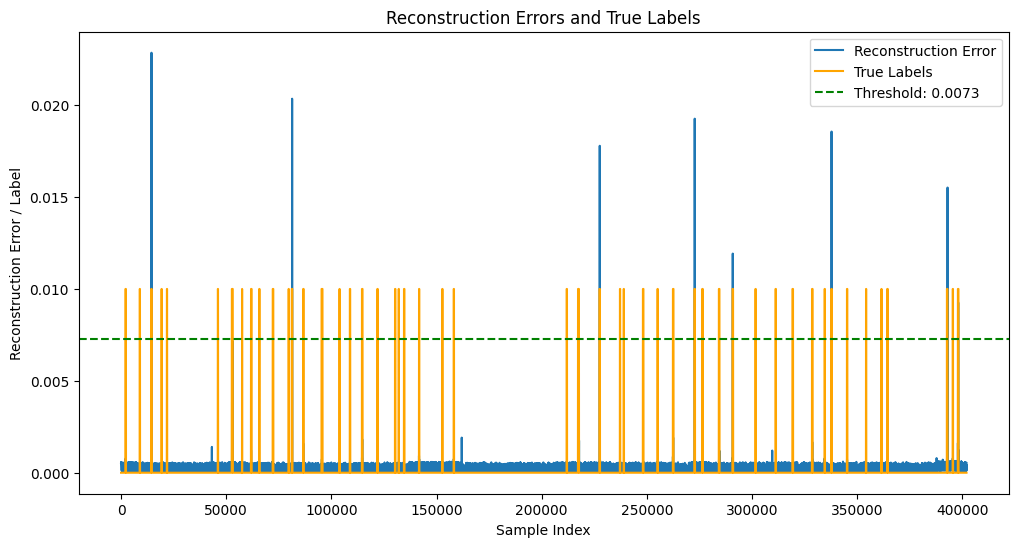

In [28]:
# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors*0.1, label='Reconstruction Error')
plt.plot(test_labels*0.01, label='True Labels', color='orange')
plt.axhline(y=optimal_threshold, color='g', linestyle='--', label=f'Threshold: {optimal_threshold:.4f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error / Label')
plt.title('Reconstruction Errors and True Labels')
plt.legend()
plt.show()